# 📚 | Import Libraries and Configurations

In [1]:
import os
import cv2
import torch
import joblib
import timm
import torch.nn as nn
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torchmetrics.regression import R2Score
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import OneCycleLR
from torchvision.models import efficientnet

In [2]:
# Set a seed for PyTorch
seed_value = 42
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)

# Set a seed for NumPy (if you're using NumPy alongside PyTorch)
np.random.seed(seed_value)

In [3]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    model_name = 'tf_efficientnetv2_b2'  # Name of pretrained classifier
    image_size = 224  # Input image size
    epochs = 12 # Training epochs
    batch_size = 96  # Batch size
    lr = 1e-4
    drop_remainder = True  # Drop incomplete batches
    num_classes = 6 # Number of classes in the dataset
    num_folds = 5 # Number of folds to split the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['X4_mean', 'X11_mean', 'X18_mean',
                   'X26_mean', 'X50_mean', 'X3112_mean',]
    aux_class_names = list(map(lambda x: x.replace("mean","sd"), class_names))
    num_classes = len(class_names)
    aux_num_classes = len(aux_class_names)

In [4]:
BASE_PATH = "/kaggle/input/planttraits2024"

In [5]:
CFG.aux_class_names

['X4_sd', 'X11_sd', 'X18_sd', 'X26_sd', 'X50_sd', 'X3112_sd']

In [6]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['image_path'] = f'{BASE_PATH}/train_images/'+df['id'].astype(str)+'.jpeg'
df.loc[:, CFG.aux_class_names] = df.loc[:, CFG.aux_class_names].fillna(-1)
display(df.head(2))

# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['image_path'] = f'{BASE_PATH}/test_images/'+test_df['id'].astype(str)+'.jpeg'
FEATURE_COLS = test_df.columns[1:-1].tolist()
display(test_df.head(2))

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,image_path
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054,/kaggle/input/planttraits2024/train_images/192...
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477,/kaggle/input/planttraits2024/train_images/195...


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12,image_path
0,195066138,10.55810,961.500000,31.586735,13.728325,648.038208,25.351532,127,152,137,...,0.469694,0.455849,0.528211,0.555653,0.549882,0.542905,0.517507,0.462724,0.427107,/kaggle/input/planttraits2024/test_images/1950...
1,195524180,7.00287,1120.025513,23.000000,7.258863,973.889404,39.135712,106,167,127,...,0.428838,0.456266,0.470074,0.468038,0.475943,0.483206,0.477197,0.432732,0.423728,/kaggle/input/planttraits2024/test_images/1955...


In [7]:
FEATURE_COLS = test_df.columns[1:-1].tolist()

# 🔬 | Dataset & DataLoader

The DataLoader efficiently manages the processing of JPEG images and tabular features as inputs, handling labels for both the main and auxiliary tasks simultaneously.

In [8]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

class PlantDataset(Dataset):
    def __init__(self, paths, features, labels=None, aux_labels=None, transform=None, augment=False):
        self.paths = paths
        self.features = features
        self.labels = labels
        self.aux_labels = aux_labels
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        feature = self.features[idx]

        # Read and decode image
        image = self.decode_image(path)

        # Apply augmentations
        if self.augment:
            augmented = self.transform(image=image)
            image = augmented['image']            
        else:
            # Ensure channel dimension is the first one
            image = np.transpose(image, (2, 0, 1))
            image = torch.tensor(image, dtype=torch.float32)


        if self.labels is not None:
            label = torch.tensor(self.labels[idx])
            aux_label = torch.tensor(self.aux_labels[idx])
            return {'images': image, 'features': feature}, (label, aux_label)
        else:
            return {'images': image, 'features': feature}

    def decode_image(self, path):
        image = Image.open(path)
        image = image.resize((CFG.image_size,CFG.image_size))
        image = np.array(image)
        return image

def build_augmenter():
    # Define Albumentations augmentations
    transform = A.Compose([
        A.RandomBrightness(limit=0.1, always_apply=False, p=0.5),
        A.RandomContrast(limit=0.1, always_apply=False, p=0.5),
        A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit=0.1, val_shift_limit=0.1, p=0.5),
        A.Cutout(num_holes=1, max_h_size=32, max_w_size=32, always_apply=False, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=5, p=0.5),
        ToTensorV2(),
    ])

    return transform

In [9]:
def build_dataset(paths, features, labels=None, aux_labels=None, batch_size=32, cache=True, augment=True, repeat=True, shuffle=1024, cache_dir="", drop_remainder=False):
    dataset = PlantDataset(paths, features, labels, aux_labels, transform=build_augmenter(), augment=augment)

    if cache_dir != "" and cache:
        os.makedirs(cache_dir, exist_ok=True)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4, drop_last=drop_remainder, pin_memory=True)

    return dataloader

In [10]:
from sklearn.model_selection import StratifiedKFold

# Assuming df is your dataframe containing file paths, features, labels, and fold information
skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=42)

# Create separate bin for each trait
for i, trait in enumerate(CFG.class_names):
    bin_edges = np.percentile(df[trait], np.linspace(0, 100, CFG.num_folds + 1))
    df[f"bin_{i}"] = np.digitize(df[trait], bin_edges)

df["final_bin"] = df[[f"bin_{i}" for i in range(len(CFG.class_names))]].astype(str).agg("".join, axis=1)

df["fold"] = -1  # Initialize fold column

# Perform the stratified split using final bin
for fold, (train_idx, valid_idx) in enumerate(skf.split(df, df["final_bin"])):
    df.loc[valid_idx, "fold"] = fold

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [11]:
# Sample from full data
sample_df = df.copy()
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Normalize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[FEATURE_COLS].values)
valid_features = scaler.transform(valid_df[FEATURE_COLS].values)

# Num Train: 44391 | Num Valid: 11098


In [12]:
train_df

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X3112_sd,image_path,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,final_bin,fold
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,15.045054,/kaggle/input/planttraits2024/train_images/192...,2,2,1,2,4,1,221241,2
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,11.004477,/kaggle/input/planttraits2024/train_images/195...,3,3,2,2,2,3,332223,1
3,195728812,18.680834,1473.933350,163.100006,45.009758,381.053986,20.436666,120,131,125,...,141.857187,/kaggle/input/planttraits2024/train_images/195...,3,2,3,1,2,3,323123,4
4,195251545,0.673204,530.088867,50.857777,38.230709,1323.526855,45.891998,91,146,120,...,87.146899,/kaggle/input/planttraits2024/train_images/195...,2,3,3,4,5,4,233454,2
5,195733955,12.062123,1982.033325,320.138092,74.343796,318.258270,17.557619,101,142,120,...,14.671018,/kaggle/input/planttraits2024/train_images/195...,3,5,3,5,1,2,353512,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55481,193145264,15.907291,1166.500000,184.500000,72.396286,280.652466,20.049999,119,128,122,...,-1.000000,/kaggle/input/planttraits2024/train_images/193...,1,2,2,2,4,2,122242,1
55482,170161513,7.772279,842.102051,43.357143,20.809752,688.702271,26.403061,114,158,131,...,12.478736,/kaggle/input/planttraits2024/train_images/170...,3,3,2,2,3,2,332232,2
55483,194246645,10.237585,746.724487,38.000000,17.433586,499.778442,26.671429,108,136,122,...,-1.000000,/kaggle/input/planttraits2024/train_images/194...,1,2,2,3,4,2,122342,4
55485,194523231,13.724150,1450.000000,162.260208,43.139324,652.716858,26.694387,125,144,135,...,136.503697,/kaggle/input/planttraits2024/train_images/194...,2,1,3,4,5,4,213454,1


In [13]:
# Extract file paths, features, labels, and fold information for train and validation sets
train_paths = train_df.image_path.values
train_labels = train_df[CFG.class_names].values
train_aux_labels = train_df[CFG.aux_class_names].values

valid_paths = valid_df.image_path.values
valid_labels = valid_df[CFG.class_names].values
valid_aux_labels = valid_df[CFG.aux_class_names].values

# Build datasets
train_dataloader = build_dataset(train_paths, train_features, train_labels, train_aux_labels,
                         batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=True, cache=False)
valid_dataloader = build_dataset(valid_paths, valid_features, valid_labels, valid_aux_labels,
                         batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=False)

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


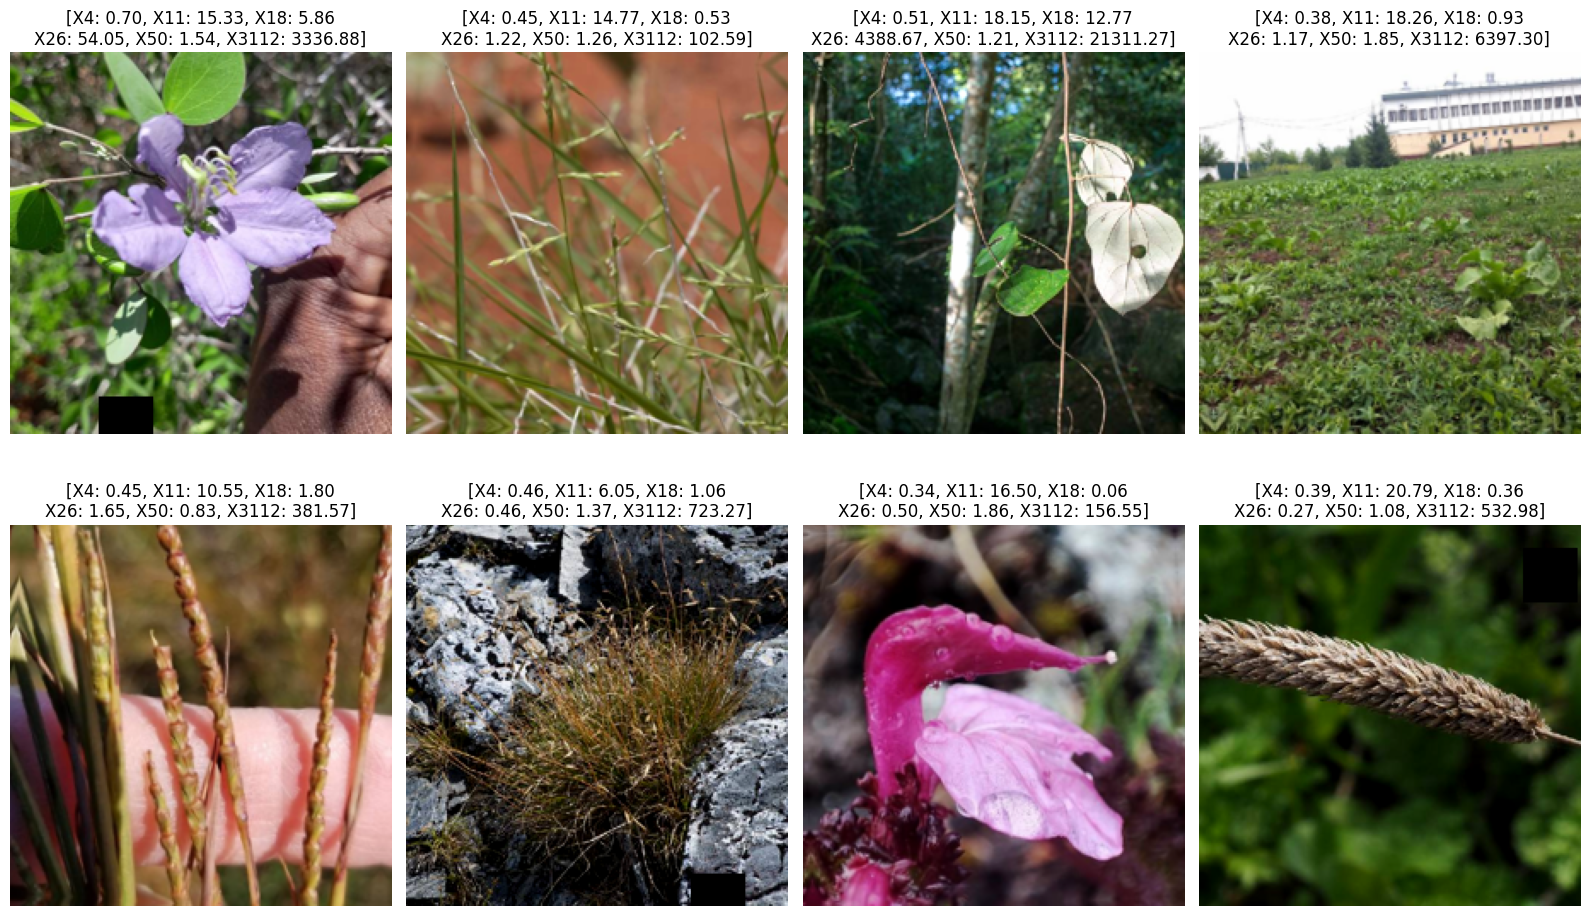

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of data
inps, tars = next(iter(train_dataloader))
imgs = inps["images"]
num_imgs, num_cols = 8, 4

# Convert PyTorch tensors to NumPy arrays
imgs_np = imgs.numpy()
tars_np = tars[0].numpy()

plt.figure(figsize=(4 * num_cols, num_imgs // num_cols * 5))

for i, (img, tar) in enumerate(zip(imgs_np[:num_imgs], tars_np[:num_imgs])):
    plt.subplot(num_imgs // num_cols, num_cols, i + 1)

    # Normalize the image to [0, 1]
    img = (img - img.min()) / (img.max() - img.min() + 1e-4)

    formatted_tar = "\n".join(
        [
            ", ".join(
                f"{name.replace('_mean','')}: {val:.2f}"
                for name, val in zip(CFG.class_names[j : j + 3], tar[j : j + 3])
            )
            for j in range(0, len(CFG.class_names), 3)
        ]
    )

    plt.imshow(img.transpose(1, 2, 0))  # Transpose to (height, width, channels)
    plt.title(f"[{formatted_tar}]")
    plt.axis("off")

plt.tight_layout()
plt.show()

# 🤖 | Modeling & Configuration

In [15]:
class CustomModel(nn.Module):
    def __init__(self, num_classes, aux_num_classes, feature_cols, model_name='efficientnetv2_s'):
        super(CustomModel, self).__init__()

        # Define input layers
        self.img_input = nn.Identity()
        self.feat_input = nn.Identity()

        # Load pre-trained EfficientNetV2 model
        self.backbone = timm.create_model(model_name, pretrained=True)

        # Adapt the model to match the expected output size
        self.backbone.global_pool = nn.AdaptiveAvgPool2d(1)
        self.backbone.classifier = nn.Identity()

        self.dropout_img = nn.Dropout(0.2)

        # Branch for tabular/feature input
        self.dense1 = nn.Linear(len(feature_cols), 326)
        self.dense2 = nn.Linear(326, 64)
        self.dropout_feat = nn.Dropout(0.1)

        # Output layer
        self.head = nn.Linear(1472, num_classes)
        self.aux_head = nn.Linear(1472, aux_num_classes)

    def forward(self, img, feat):
        # Image branch
        x1 = self.backbone(img)
        x1 = self.dropout_img(x1.flatten(1))

        # Feature branch
        x2 = F.selu(self.dense1(self.feat_input(feat)))
        x2 = F.selu(self.dense2(x2))
        x2 = self.dropout_feat(x2)

        # Concatenate both branches
        concat = torch.cat([x1, x2], dim=1)
        # Output layer
        out1 = self.head(concat)
        out2 = F.relu(self.aux_head(concat))

        return {'head': out1, 'aux_head': out2}

In [16]:
# Instantiate the model with the desired EfficientNetV2 model_name
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomModel(CFG.num_classes, CFG.aux_num_classes, FEATURE_COLS, model_name=CFG.model_name)
model.to(device)
# Print the model summary
#print(model)

model.safetensors:   0%|          | 0.00/40.8M [00:00<?, ?B/s]

CustomModel(
  (img_input): Identity()
  (feat_input): Identity()
  (backbone): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Ide

In [17]:
class R2Loss(nn.Module):
    def __init__(self, use_mask=False):
        super(R2Loss, self).__init__()
        self.use_mask = use_mask

    def forward(self, y_true, y_pred):
        if self.use_mask:
            mask = (y_true != -1)
            y_true = torch.where(mask, y_true, torch.zeros_like(y_true))
            y_pred = torch.where(mask, y_pred, torch.zeros_like(y_pred))

        SS_res = torch.sum((y_true - y_pred)**2, dim=0)  # (B, C) -> (C,)
        SS_tot = torch.sum((y_true - torch.mean(y_true, dim=0))**2, dim=0)  # (B, C) -> (C,)
        r2_loss = SS_res / (SS_tot + 1e-6)  # (C,)
        return torch.mean(r2_loss)  # ()

class R2Metric(nn.Module):
    def __init__(self, num_classes=6):
        super(R2Metric, self).__init__()
        self.num_classes = num_classes
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.reset()

    def reset(self):
        self.SS_res = torch.zeros(self.num_classes, device=self.device)
        self.SS_tot = torch.zeros(self.num_classes, device=self.device)
        self.num_samples = torch.tensor(0, dtype=torch.float32, device=self.device)

    def forward(self, y_true, y_pred):
        y_true = y_true.to(self.device)
        y_pred = y_pred.to(self.device)

        SS_res = torch.sum((y_true - y_pred)**2, dim=0)
        SS_tot = torch.sum((y_true - torch.mean(y_true, dim=0))**2, dim=0)
        self.SS_res += SS_res
        self.SS_tot += SS_tot
        self.num_samples += y_true.size(0)

    def compute(self):
        r2 = 1 - self.SS_res / (self.SS_tot + 1e-6)
        return torch.mean(r2)

In [18]:
def get_lr_scheduler(optimizer, dataloader, epochs, max_lr, steps_per_epoch, pct_start=0.3, div_factor=25.0, final_div_factor=1e4):
    total_steps = steps_per_epoch * epochs
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=pct_start, div_factor=div_factor, final_div_factor=final_div_factor)

    def lr_lambda(step):
        return scheduler.get_lr()

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


In [19]:
# Define loss functions and metrics
criterion_head = R2Loss(use_mask=False)
criterion_aux_head = R2Loss(use_mask=True)

# Loss weights
weight_head = 1.0
weight_aux_head = 0.3

# Model checkpoint
best_model_path = "best_model.pth"
best_r2_score = -float('inf')
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)

In [20]:
import torch
import torch.optim as optim
from torchmetrics.regression import R2Score
from tqdm import tqdm

# Assuming that you have already defined your model, dataloaders, and other necessary configurations

# Initialize the R2Score metric
metric_head = R2Score(num_outputs=6, multioutput='uniform_average').to(device)

# Training loop
for epoch in range(CFG.epochs):
    # Training
    model.train()
    total_train_r2 = 0.0
    train_batches = 0

    for batch_idx, (inputs_dict, (targets, aux_targets)) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()

        # Move data to GPU
        inputs_images = inputs_dict['images'].to(device, dtype=torch.float32)
        inputs_features = inputs_dict['features'].to(device, dtype=torch.float32)
        targets = targets.to(device, dtype=torch.float32)
        aux_targets = aux_targets.to(device, dtype=torch.float32)

        # Forward pass
        outputs = model(inputs_images, inputs_features)

        # Compute losses
        loss_head = weight_head * criterion_head(outputs['head'], targets)
        loss_aux_head = weight_aux_head * criterion_aux_head(outputs['aux_head'], aux_targets)
        loss = loss_head + loss_aux_head

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the R2 metric
        r2_value = metric_head(outputs['head'], targets)
        total_train_r2 += r2_value.item()
        train_batches += 1

    # Compute the average training R2 score
    avg_train_r2 = total_train_r2 / train_batches
    print(f"Epoch {epoch + 1}/{CFG.epochs}, Average Train R2 Score: {avg_train_r2}")

    # Validation
    model.eval()
    total_val_r2 = 0.0
    val_batches = 0

    with torch.no_grad():
        for val_batch_idx, (val_inputs_dict, (val_targets, val_aux_targets)) in enumerate(tqdm(valid_dataloader)):
            val_inputs_images = val_inputs_dict['images'].to(device, dtype=torch.float32)
            val_inputs_features = val_inputs_dict['features'].to(device, dtype=torch.float32)
            val_targets = val_targets.to(device, dtype=torch.float32)
            val_aux_targets = val_aux_targets.to(device, dtype=torch.float32)

            val_outputs = model(val_inputs_images, val_inputs_features)

            # Compute the R2 metric for validation
            r2_value = metric_head(val_outputs['head'], val_targets)
            total_val_r2 += r2_value.item()
            val_batches += 1

    # Compute the average validation R2 score
    avg_val_r2 = total_val_r2 / val_batches
    print(f"Epoch {epoch + 1}/{CFG.epochs}, Average Val R2 Score: {avg_val_r2}")

    # Save the best model based on validation R2 score
    if avg_val_r2 > best_r2_score:
        best_r2_score = avg_val_r2
        torch.save(model.state_dict(), best_model_path)

100%|██████████| 463/463 [03:25<00:00,  2.25it/s]


Epoch 1/12, Average Train R2 Score: -6.827835671008277


100%|██████████| 116/116 [00:51<00:00,  2.27it/s]


Epoch 1/12, Average Val R2 Score: -11.744524254881103


100%|██████████| 463/463 [02:56<00:00,  2.62it/s]


Epoch 2/12, Average Train R2 Score: -18.041178733689737


100%|██████████| 116/116 [00:30<00:00,  3.76it/s]


Epoch 2/12, Average Val R2 Score: -20.01918209010157


100%|██████████| 463/463 [02:56<00:00,  2.62it/s]


Epoch 3/12, Average Train R2 Score: -23.91783912753441


100%|██████████| 116/116 [00:31<00:00,  3.73it/s]


Epoch 3/12, Average Val R2 Score: -36.92979074346608


100%|██████████| 463/463 [02:57<00:00,  2.61it/s]


Epoch 4/12, Average Train R2 Score: -32.58185714058433


100%|██████████| 116/116 [00:30<00:00,  3.77it/s]


Epoch 4/12, Average Val R2 Score: -42.07734244034208


100%|██████████| 463/463 [02:57<00:00,  2.61it/s]


Epoch 5/12, Average Train R2 Score: -32.91027898046934


100%|██████████| 116/116 [00:31<00:00,  3.67it/s]


Epoch 5/12, Average Val R2 Score: -48.097182536947315


100%|██████████| 463/463 [02:56<00:00,  2.62it/s]


Epoch 6/12, Average Train R2 Score: -58.14043554425497


100%|██████████| 116/116 [00:31<00:00,  3.66it/s]


Epoch 6/12, Average Val R2 Score: -79.943066227025


100%|██████████| 463/463 [02:57<00:00,  2.60it/s]


Epoch 7/12, Average Train R2 Score: -71.01633253777258


100%|██████████| 116/116 [00:30<00:00,  3.79it/s]


Epoch 7/12, Average Val R2 Score: -103.02195498038982


100%|██████████| 463/463 [02:57<00:00,  2.61it/s]


Epoch 8/12, Average Train R2 Score: -79.00722802946943


100%|██████████| 116/116 [00:30<00:00,  3.76it/s]


Epoch 8/12, Average Val R2 Score: -145.46400384245248


100%|██████████| 463/463 [02:57<00:00,  2.61it/s]


Epoch 9/12, Average Train R2 Score: -84.36508997470204


100%|██████████| 116/116 [00:31<00:00,  3.74it/s]


Epoch 9/12, Average Val R2 Score: -185.90334431878452


100%|██████████| 463/463 [02:57<00:00,  2.61it/s]


Epoch 10/12, Average Train R2 Score: -115.41933179159143


100%|██████████| 116/116 [00:30<00:00,  3.81it/s]


Epoch 10/12, Average Val R2 Score: -179.96809273752672


100%|██████████| 463/463 [02:58<00:00,  2.60it/s]


Epoch 11/12, Average Train R2 Score: -129.70838708856965


100%|██████████| 116/116 [00:30<00:00,  3.79it/s]


Epoch 11/12, Average Val R2 Score: -215.58494576914558


100%|██████████| 463/463 [02:57<00:00,  2.61it/s]


Epoch 12/12, Average Train R2 Score: -55.291646605176496


100%|██████████| 116/116 [00:30<00:00,  3.78it/s]

Epoch 12/12, Average Val R2 Score: -62.73502169395315


In [21]:
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [22]:
# Test
test_paths = test_df.image_path.values
test_features = scaler.transform(test_df[FEATURE_COLS].values) 
test_ds = build_dataset(test_paths, test_features, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=False)

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


# | Evaluation

In [23]:
model.eval()  # Set the model to evaluation mode

# List to store predictions
all_predictions = []

# Iterate over batches in the test data loader
for batch_idx, inputs_dict in enumerate(tqdm(test_ds, desc='Testing')):
    # Extract images and features from the inputs_dict
    inputs_images = inputs_dict['images'].to(device, dtype=torch.float32)  # Assuming 'device' is the target device
    inputs_features = inputs_dict['features'].to(device, dtype=torch.float32)

    # Forward pass
    with torch.no_grad():
        outputs = model(inputs_images, inputs_features)

    # Get predictions
    predictions = outputs['head'].cpu().numpy()  # Assuming 'head' is the main task output

    # Append predictions to the list
    all_predictions.append(predictions)

# Concatenate predictions for all batches
all_predictions = np.concatenate(all_predictions, axis=0)

Testing: 100%|██████████| 145/145 [01:00<00:00,  2.40it/s]


In [24]:
pred_df = test_df[["id"]].copy()
target_cols = [x.replace("_mean","") for x in CFG.class_names]
pred_df[target_cols] = all_predictions.tolist()

In [25]:
sub_df = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
sub_df = sub_df[["id"]].copy()
sub_df = sub_df.merge(pred_df, on="id", how="left")
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

,id,X4,X11,X18,X26,X50,X3112
0,195066138,-0.082585,-0.339823,-0.622787,0.056889,-0.316593,-1.375539
1,195524180,0.238627,-0.390004,-0.334571,-0.399460,-0.262567,-0.766971
2,172220512,1.946971,-0.478949,-1.321425,-0.981923,-2.090491,3.023710
3,195824490,1.640525,-0.115670,-0.310064,-0.681551,-1.380291,2.720891
4,191793047,0.258771,-0.665031,-0.117275,0.047552,-0.125018,-1.462972
